In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from feature_engine.imputation import MeanMedianImputer
from sklearn.pipeline import Pipeline

# Dataset de Créditos

In [2]:
df = pd.read_csv("../CC_GENERAL.csv")
print(df.shape)
df.head()

(8950, 18)


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


# EDA

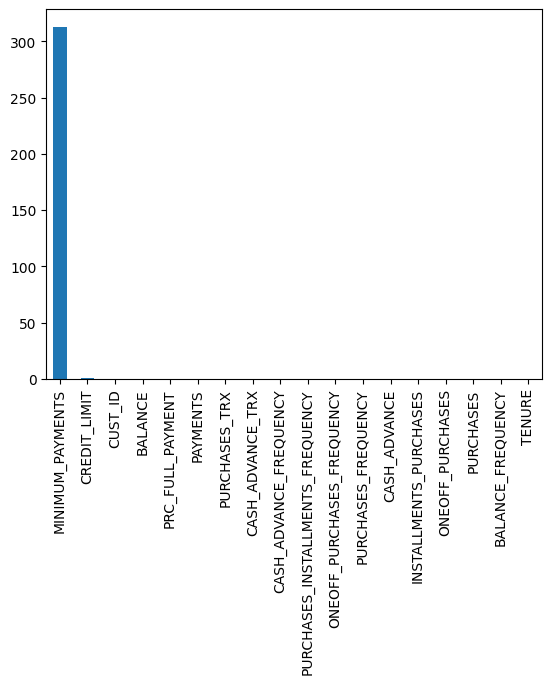

In [3]:
df.isnull().sum().sort_values(ascending=False).plot(kind = "bar");

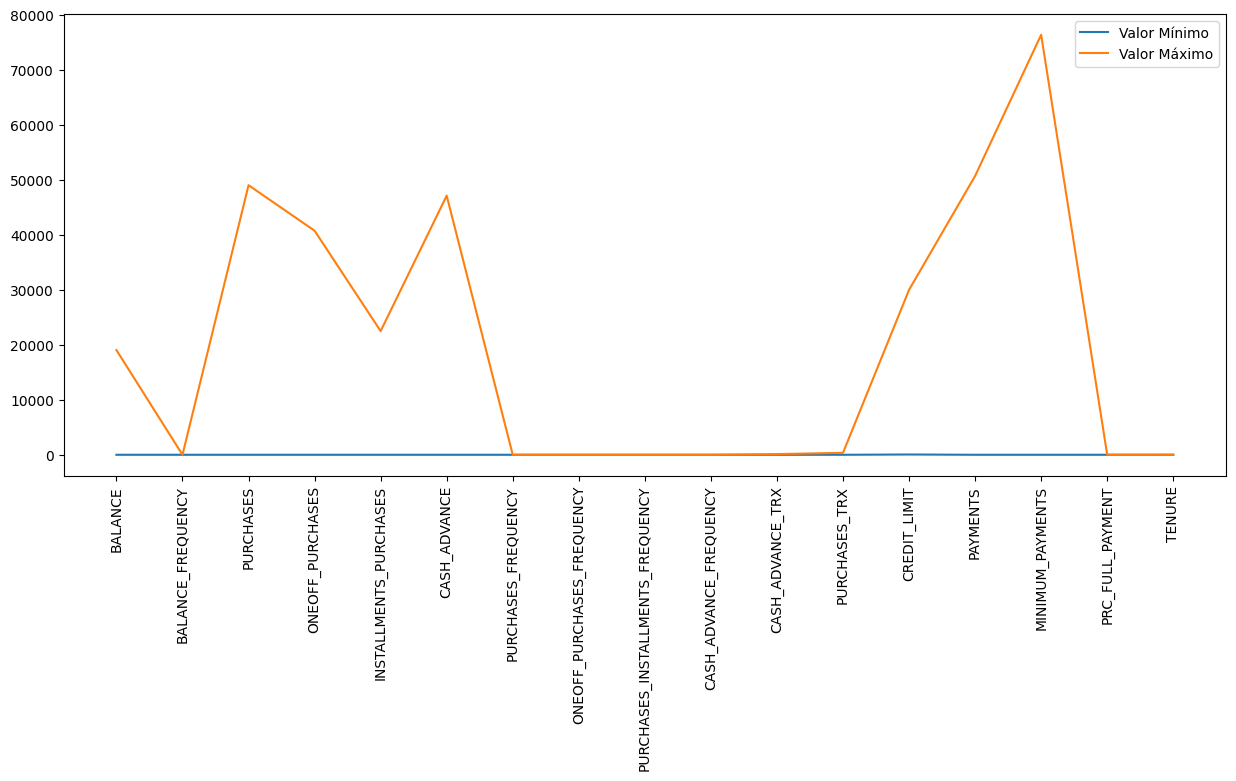

In [4]:
plt.figure(figsize = (15,6))
plt.plot(df.drop(columns = "CUST_ID").min(), label = "Valor Mínimo")
plt.plot(df.drop(columns = "CUST_ID").max(), label = "Valor Máximo")
plt.legend()
plt.xticks(rotation = 90);

In [5]:
df.CUST_ID.nunique(), len(df)

(8950, 8950)

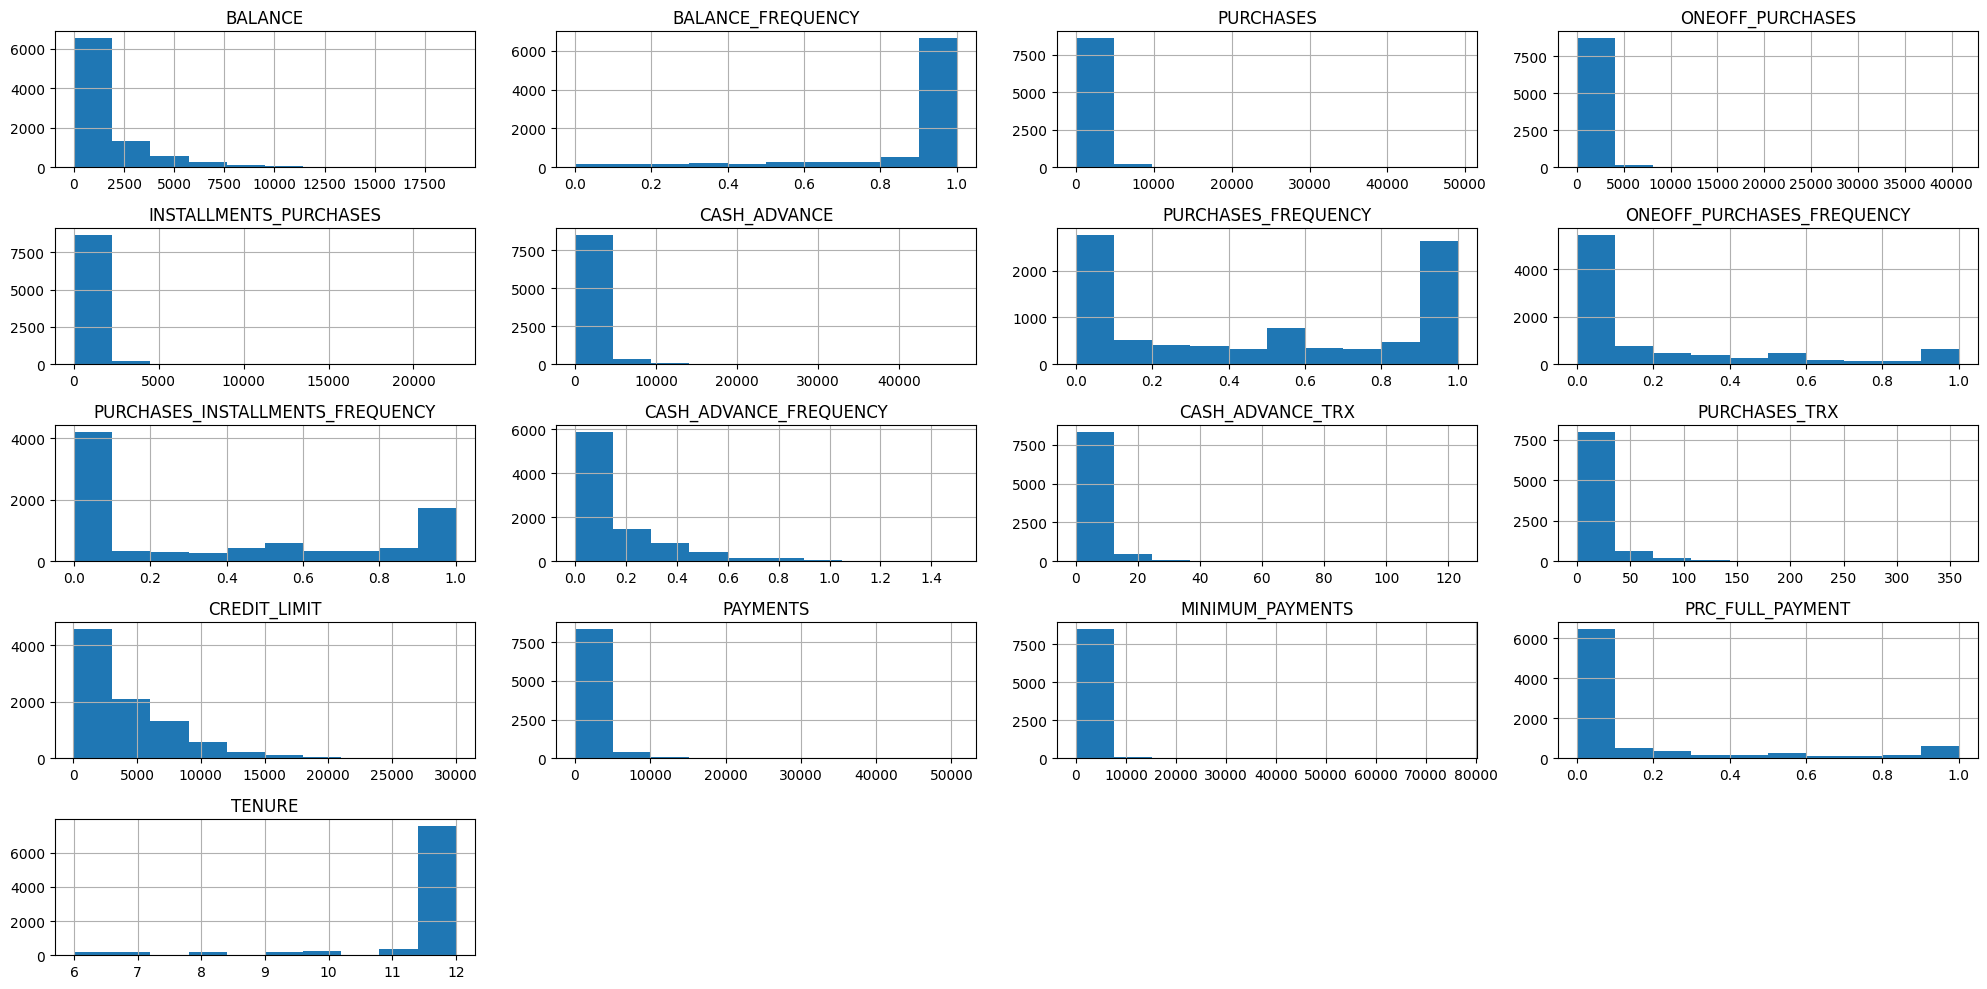

In [6]:
df.hist(figsize = (20,10))
plt.tight_layout();

# Aplicar Logaritmo

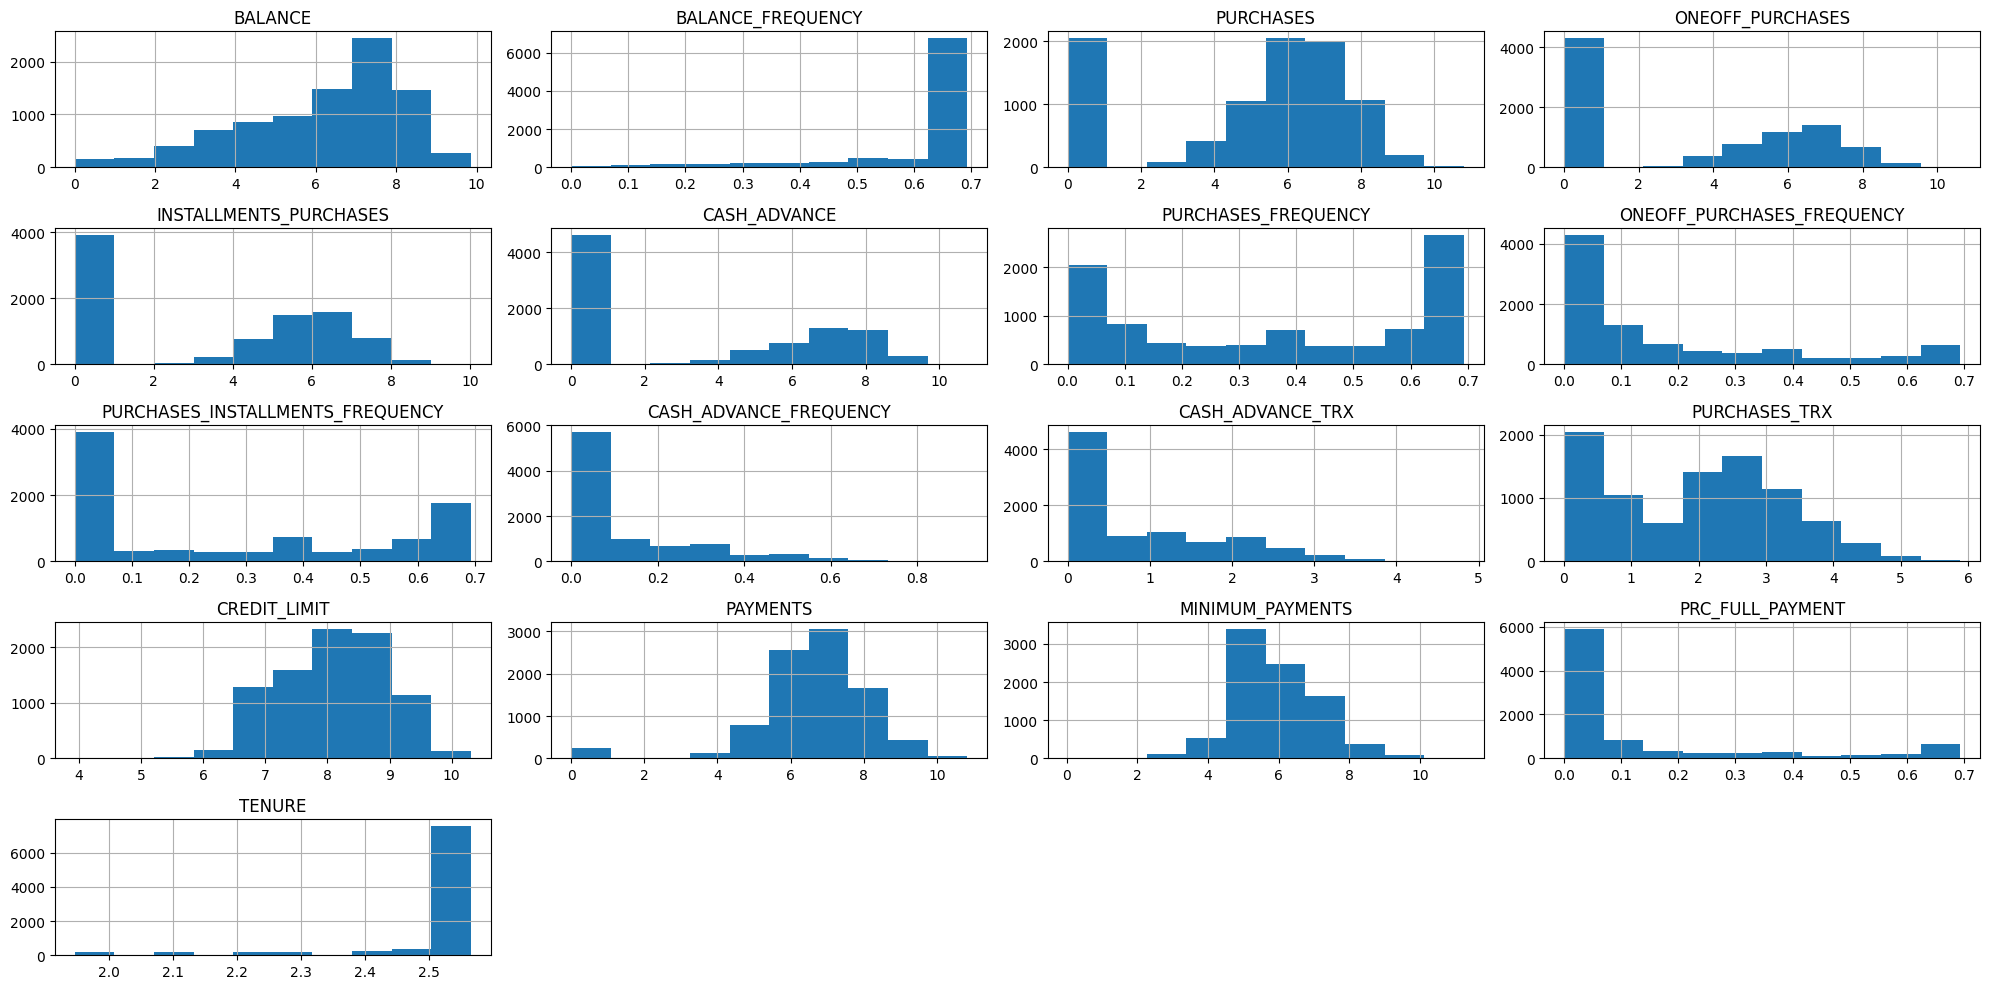

In [7]:
df.drop(columns = "CUST_ID").apply(np.log1p, axis = 1).hist(figsize = (20,10))
plt.tight_layout();

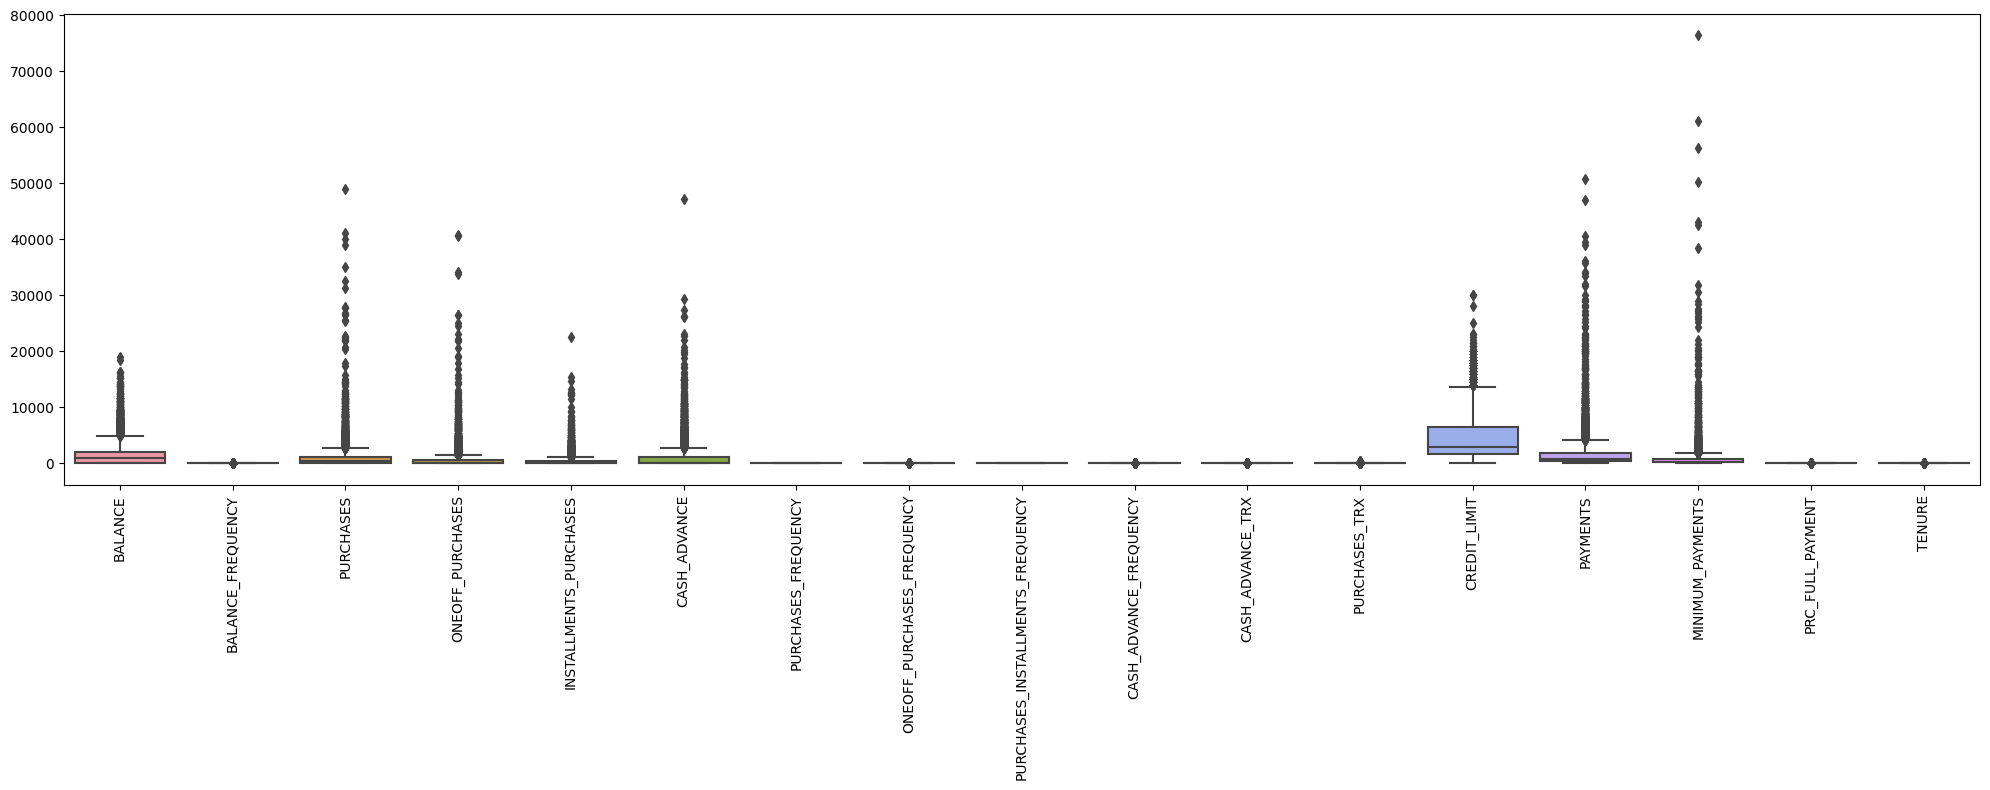

In [8]:
plt.figure(figsize=(20,8))
sns.boxplot(data=df.drop(columns = "CUST_ID"))
plt.xticks(rotation = 90);
plt.tight_layout();

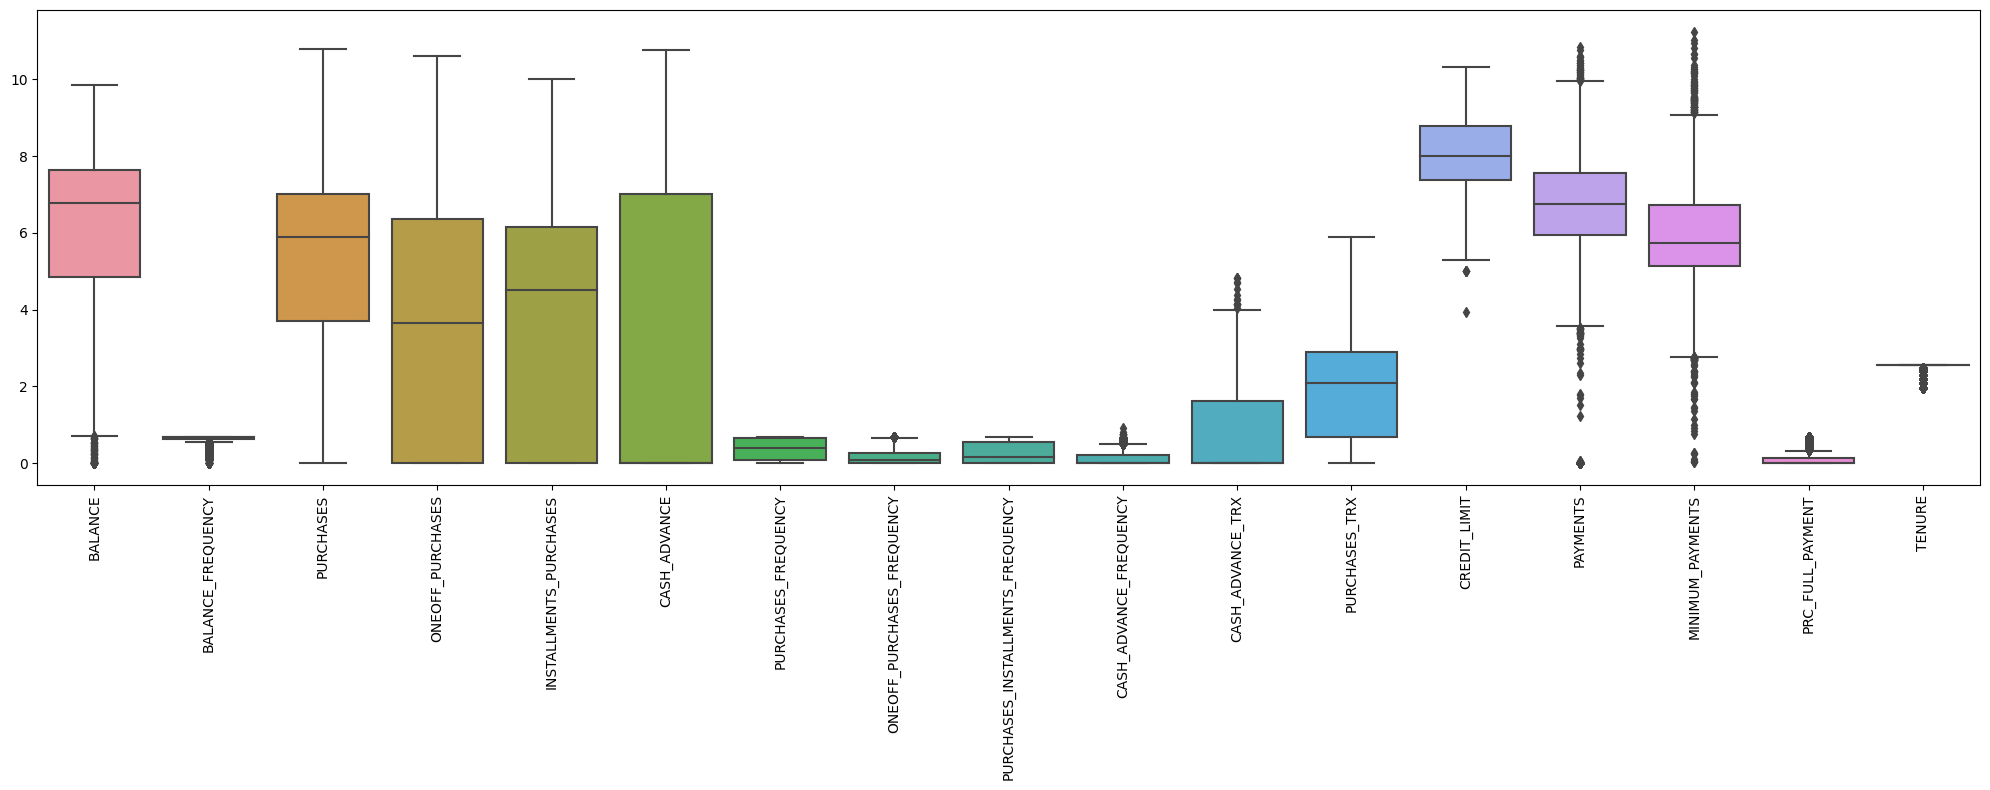

In [9]:
plt.figure(figsize=(20,8))
sns.boxplot(data=df.drop(columns = "CUST_ID").apply(np.log1p, axis = 1))
plt.xticks(rotation = 90);
plt.tight_layout();

## Determinar el número Óptimo de Clusters

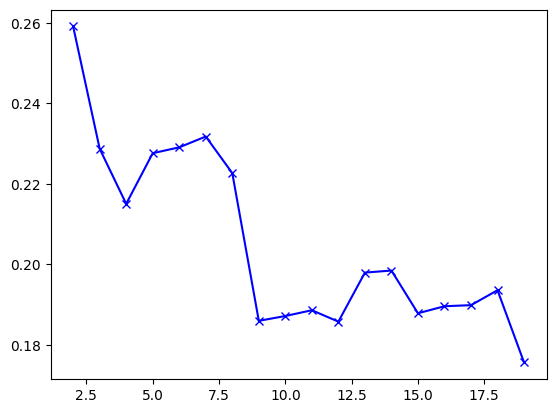

In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

prep = Pipeline(steps = [
        ("mmi", MeanMedianImputer(imputation_method="mean")),
        ("sc", StandardScaler())
        ])
X = df.drop(columns = "CUST_ID")
X = prep.fit_transform(X.apply(np.log1p, axis = 1))


def elbow_plot(X, eval_func = silhouette_score ,n_clusters = 20):
    cost=[]
    for i in range(2,n_clusters):
        m= KMeans(i, random_state=42)
        y_pred = m.fit_predict(X)
        cost.append(eval_func(X, y_pred))
    plt.plot(range(2,n_clusters), cost, 'bx-');

elbow_plot(X, n_clusters = 20)

## Modelamiento

In [12]:
class Clusterize:
    def __init__(self, X, random_state = 42):
        self.X = X
        self.random_state = random_state
        self.clusters = pd.DataFrame()
        
    def prepare_data(self, log = False):
        prep = Pipeline(steps = [
        ("mmi", MeanMedianImputer(imputation_method="mean")),
        ("sc", StandardScaler())
        ])

        if log:
            self.X = prep.fit_transform(self.X.apply(np.log1p, axis = 1))
        else:
            self.X = prep.fit_transform(self.X)


    def kmeans(self, km_clusters):
        kmeans= KMeans(n_clusters= km_clusters, random_state=self.random_state)
        kmeans.fit(self.X)

        self.clusters["clusters_km"] = kmeans.fit_predict(self.X)

    def som(self, m, n):
        from sklearn_som.som import SOM
        som = SOM(m=m, n=n, dim=self.X.shape[1], random_state = self.random_state)
        som.fit(self.X)
        self.clusters["clusters_som"] = som.predict(self.X)

    def fcm(self, fcm_clusters):
        from fcmeans import FCM
        fcm = FCM(n_clusters=fcm_clusters, random_state=self.random_state)
        fcm.fit(self.X)

        self.clusters["clusters_fcm"] = fcm.predict(self.X)

    def reduce_X(self, n_componentes = 2):
        dist = 1-cosine_similarity(self.X)

        pca = PCA(n_components=n_componentes)
        pca.fit(dist)
        self.X_PCA = pca.transform(dist)


    def run_all(self, km_clusters, m, n, fcm_clusters,log = False):
        self.prepare_data(log)
        self.kmeans(km_clusters)
        self.som(m, n)
        self.fcm(fcm_clusters)
        self.reduce_X()

        return self.clusters, self.X, self.X_PCA

colors = {0: 'red',
        1: 'blue',
        2: 'green', 
        3: 'yellow', 
        4: 'orange',  
        5:'purple',
        6:'pink',
        7:'brown',
        8:'gray',
        9:'olive',}

names = {0: 'Cluster 1', 
        1: 'Cluster 2', 
        2: 'Cluster 3', 
        3: 'Cluster 4', 
        4: 'Cluster 5',
        5:'Cluster 6',
        6:'Cluster 7',
        7:'Cluster 8',
        8:'Cluster 9',
        9:'Cluster 10'}

def plot_pca_proj(X_PCA, clusters, colors, names, figsize = (20,13), title = "Segmentación."):

    x, y = X_PCA[:, 0], X_PCA[:, 1]
    df = pd.DataFrame({'x': x, 'y':y, 'label': clusters}) 
    groups = df.groupby('label')

    fig, ax = plt.subplots(figsize=figsize) 

    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
                color=colors[name],label=names[name], mec='none')
        ax.set_aspect('auto')
        ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
        ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')
        
    ax.legend()
    ax.set_title(title)
    plt.show()


def run_model(X, km_clusters, m, n, fcm_clusters, log = False):
    cluster_models = Clusterize(X)
    clusters, data, X_PCA = cluster_models.run_all(km_clusters = km_clusters, m = m, n = n, fcm_clusters = fcm_clusters, log = log)
    df[["clusters_km","clusters_som","clusters_fcm"]] = clusters

    import scikitplot as skplt
    skplt.metrics.plot_silhouette(data, df["clusters_km"], figsize=(15,6), title = f"Silhouette KMeans con {km_clusters} clusters");
    skplt.metrics.plot_silhouette(data, df["clusters_som"], figsize=(15,6), title = f"Silhouette plot SOM con grilla de {m}x{n}");
    skplt.metrics.plot_silhouette(data, df["clusters_fcm"], figsize=(15,6), title="Silhouette plot FCM");

    plot_pca_proj(X_PCA, df["clusters_km"], colors, names, figsize = (15,6), title = "Segmentación K-Means.")
    plot_pca_proj(X_PCA, df["clusters_som"], colors, names, figsize = (15,6), title = "Segmentación SOM.")
    plot_pca_proj(X_PCA, df["clusters_fcm"], colors, names,figsize = (15,6), title = "Segmentación FCM.")
        

## 7 CLUSTERS no Log

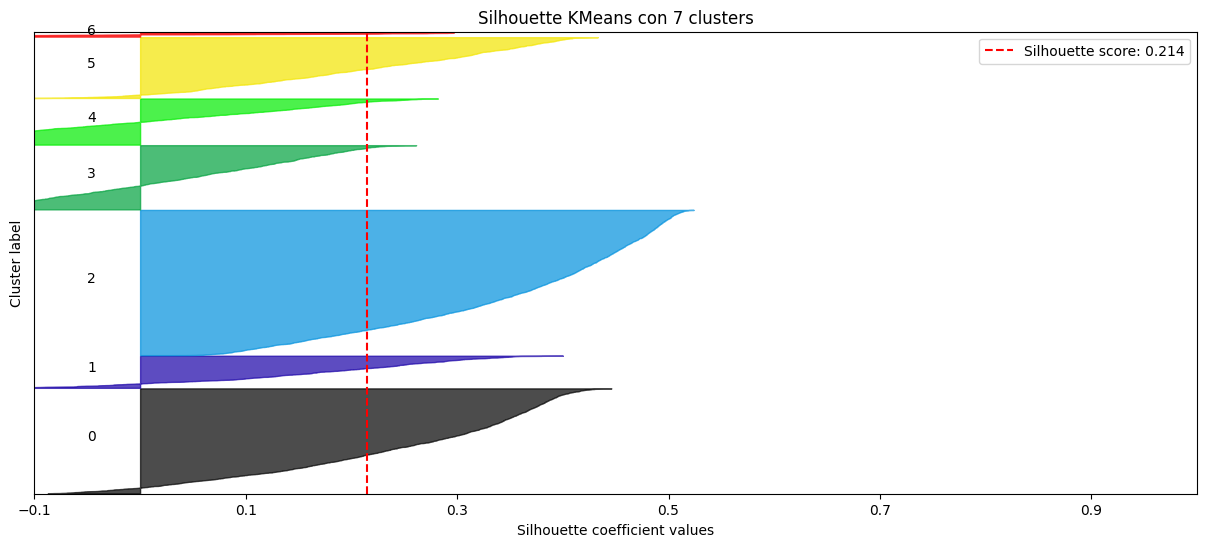

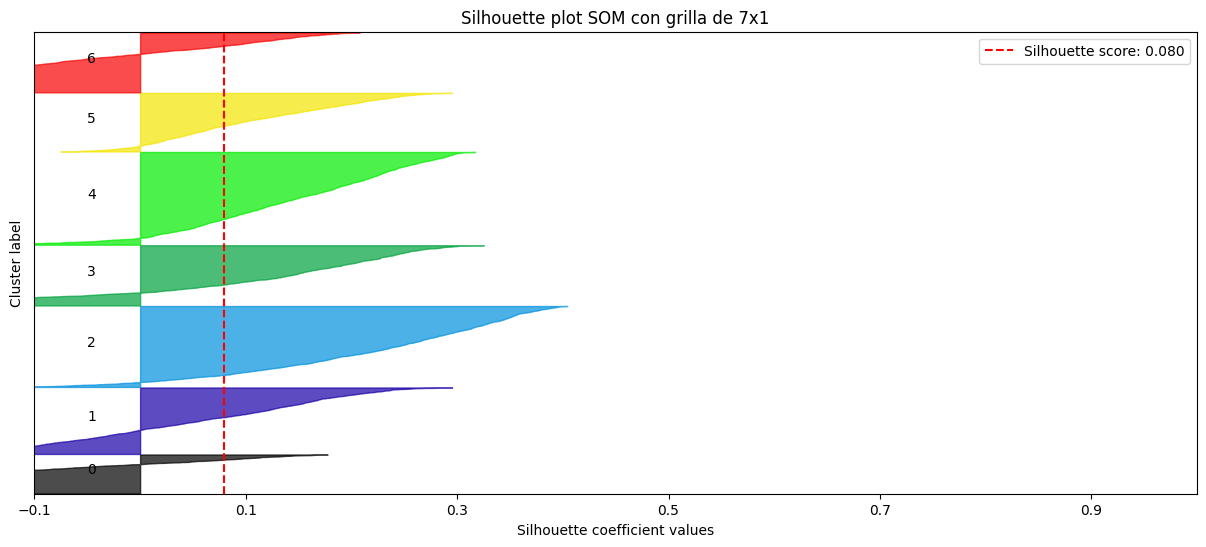

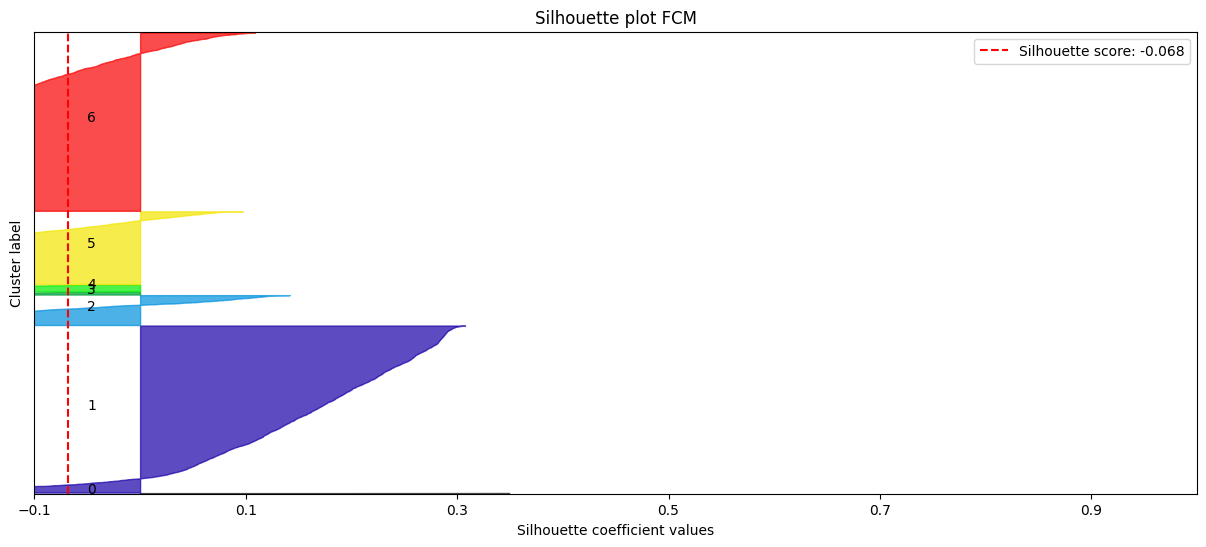

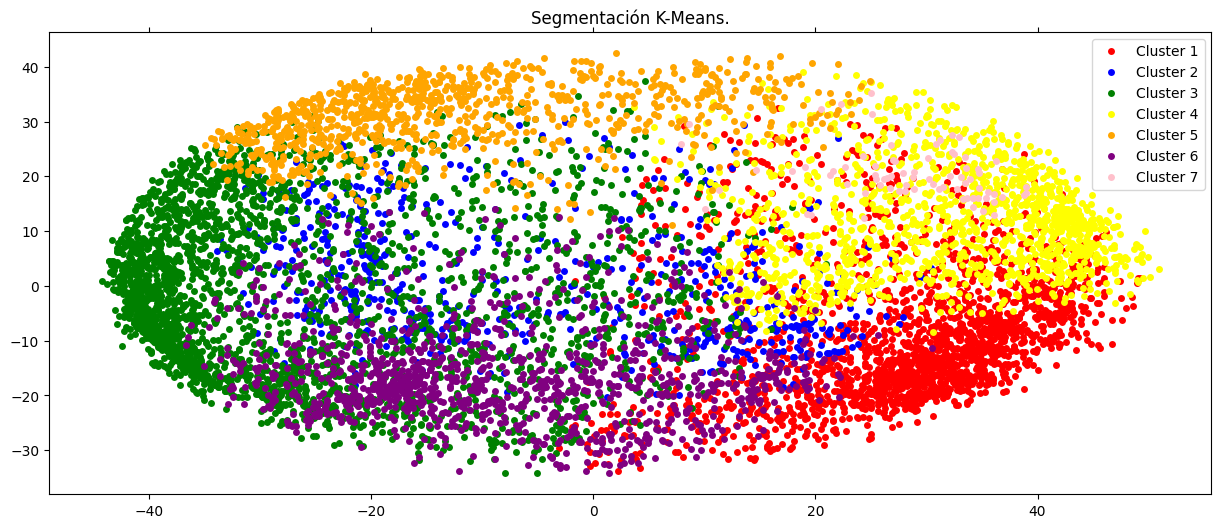

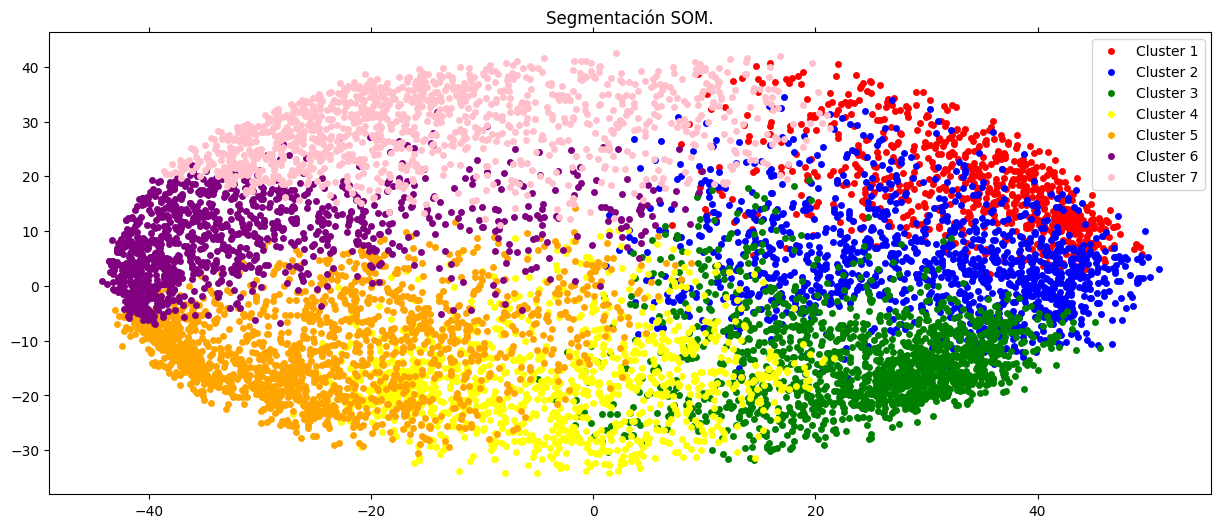

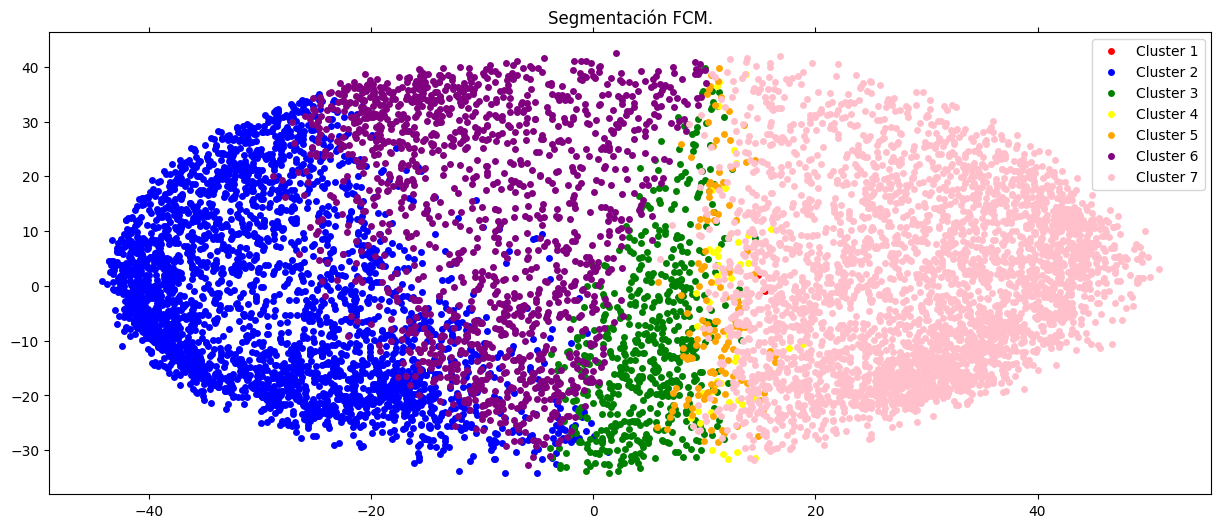

In [13]:
X = df.drop(columns = "CUST_ID")
run_model(X, km_clusters=7, m=7, n=1, fcm_clusters=7, log = False)

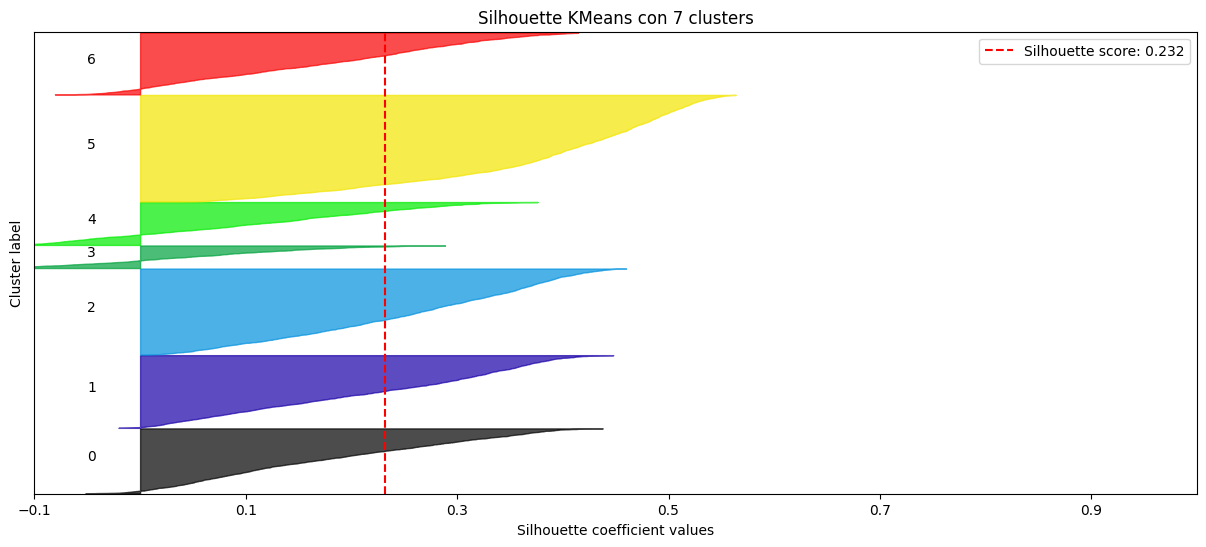

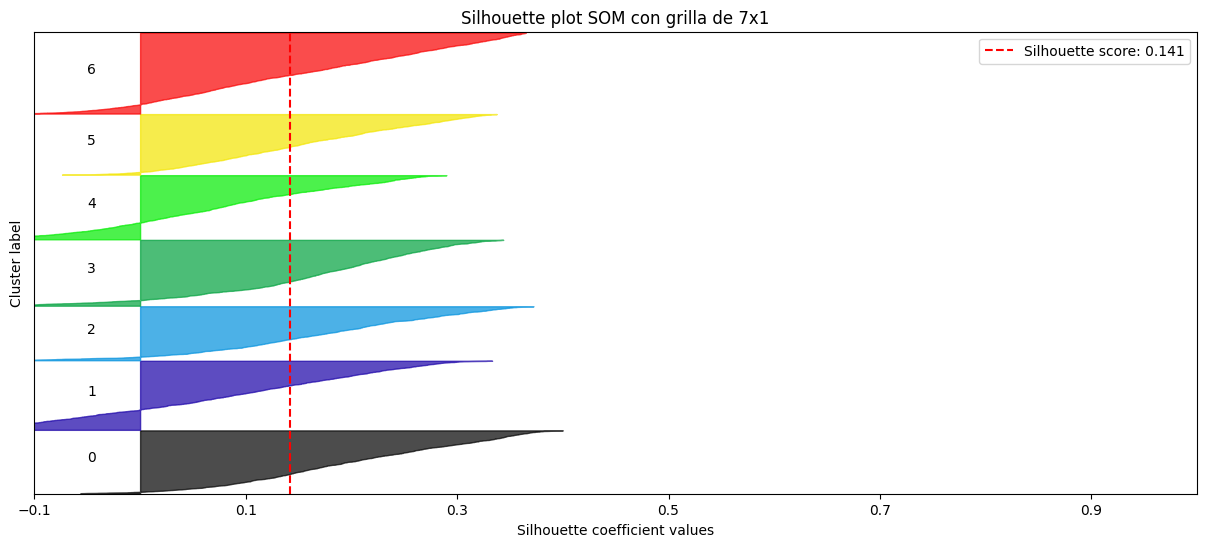

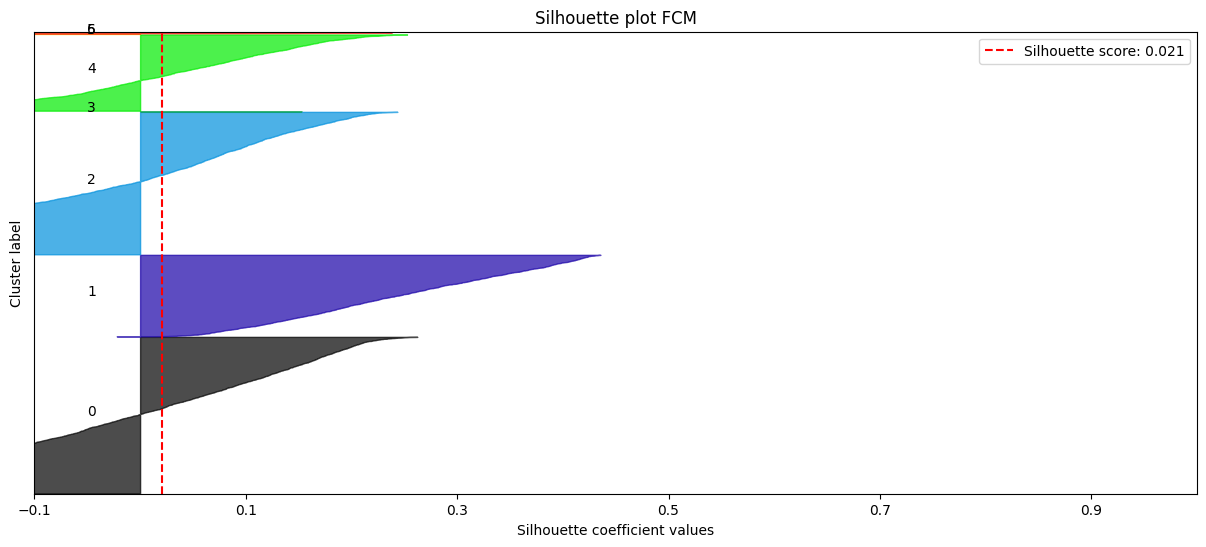

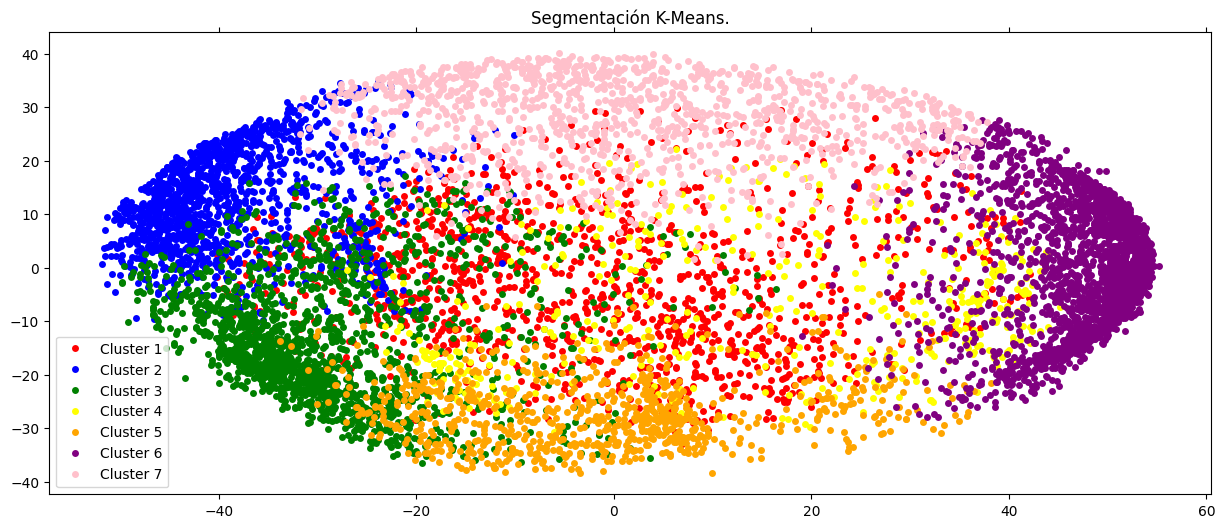

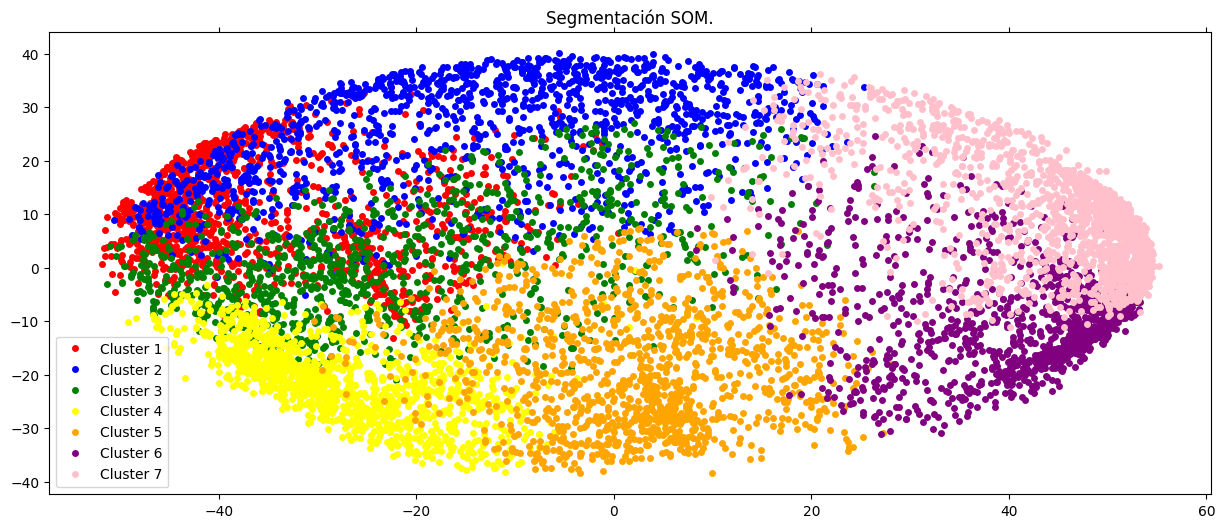

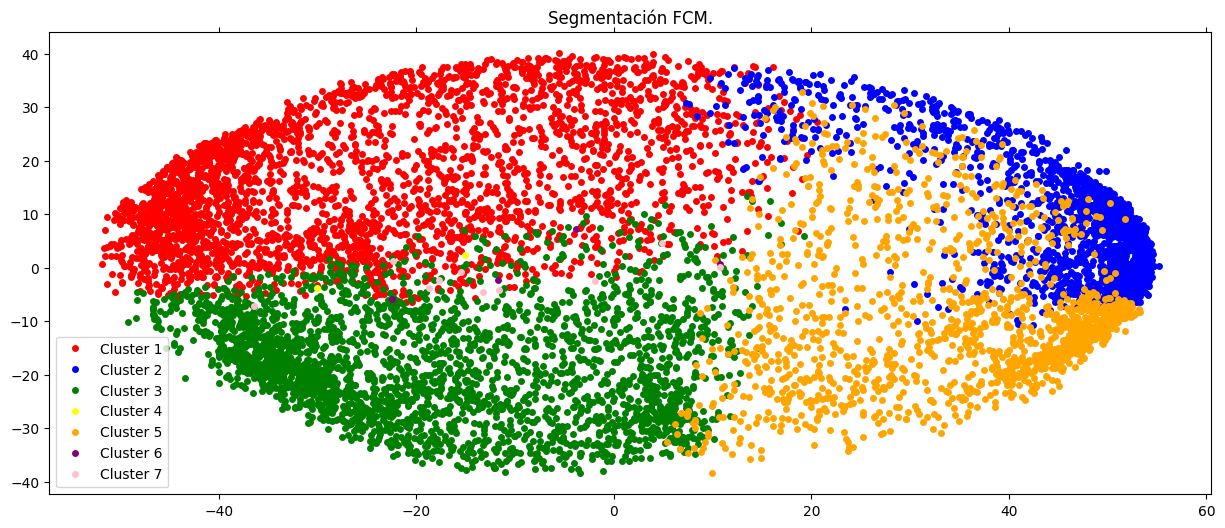

In [14]:
run_model(X, km_clusters=7, m=7, n=1, fcm_clusters=7, log = True)

In [15]:
# for col in df.drop(columns = ["CUST_ID","clusters_km"]).columns:
#     sns.displot(df, x=col, col="clusters_km");

# Utilizando otros Grillas para SOM

In [ ]:
import susi
import matplotlib.pyplot as plt
som = susi.SOMClustering(n_rows=30, n_columns = 30, random_state=42, distance_metric = "mahalanobis", n_jobs = -1)
som.fit(X)
clusters = som.get_clusters(X)


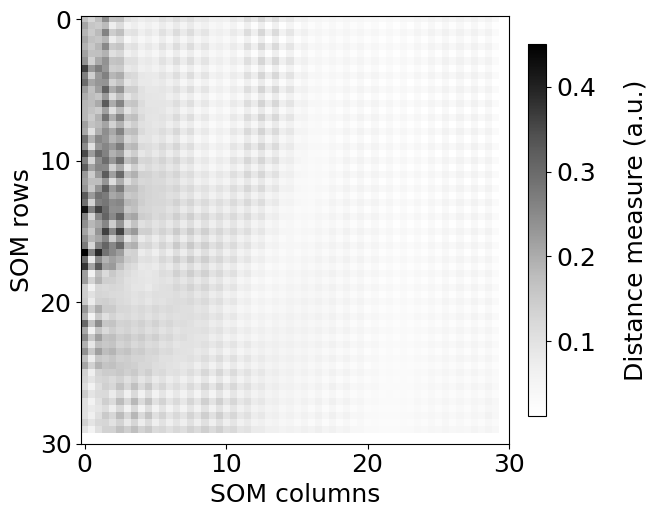

In [ ]:
import susi
from susi.SOMPlots import plot_nbh_dist_weight_matrix, plot_umatrix
u_matrix = som.get_u_matrix()
plot_umatrix(u_matrix, 30, 30)
plt.show()